#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Нужно построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Цели:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor 
from catboost import CatBoostRegressor

from sklearn.model_selection import cross_val_score, GridSearchCV , train_test_split, TimeSeriesSplit 

from sklearn.metrics import make_scorer, mean_squared_error 

In [2]:
data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0]) 

In [3]:
#Проверка хронологии расположения дат
display(data.index.is_monotonic)
data.sort_index(inplace=True)
display(data.head())
data.info()

True

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


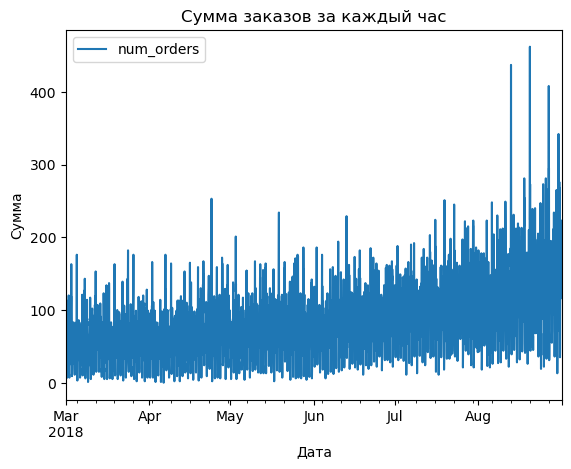

In [4]:
#Ресемплирование по сумме заказа за каждый час
data = data.resample('1H').sum() 
data.plot()
plt.title('Сумма заказов за каждый час')
plt.xlabel('Дата')
plt.ylabel('Сумма')
plt.show()

<b>Вывод</b>  
Были рассмотрены и проверены на хронологический порадок данные

## Анализ

In [5]:
#Начальная дата, конечная дата и за какой промежуток времени представлены данные
print('Начальная дата датасета:',data.index.min())
print('Конечная дата датасета:',data.index.max())
print('Количество дней в датасете:',data.index.max() - data.index.min())
print()

Начальная дата датасета: 2018-03-01 00:00:00
Конечная дата датасета: 2018-08-31 23:00:00
Количество дней в датасете: 183 days 23:00:00



In [6]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


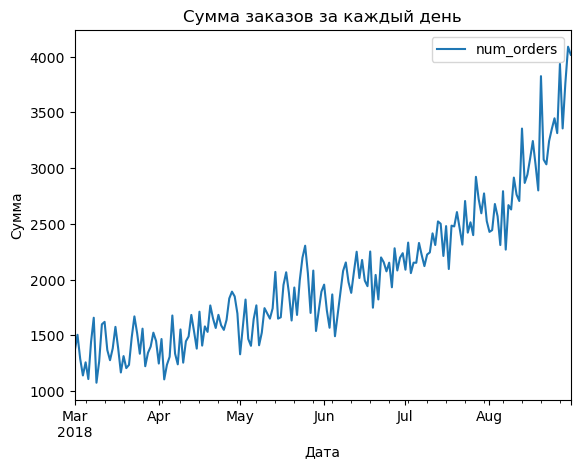

In [7]:
#Ресемплирование по сумме заказов за каждый день
data.resample('1D').sum().plot()
plt.title('Сумма заказов за каждый день')
plt.xlabel('Дата')
plt.ylabel('Сумма')
plt.show()

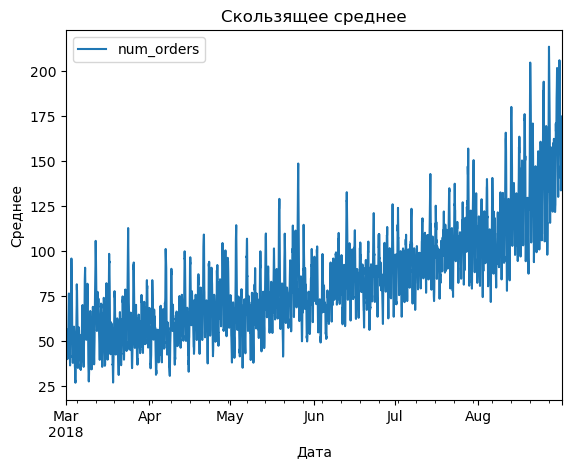

In [8]:
#Скользящее среднее
data.rolling(10).mean().plot()
plt.title('Скользящее среднее')
plt.xlabel('Дата')
plt.ylabel('Среднее')
plt.show()

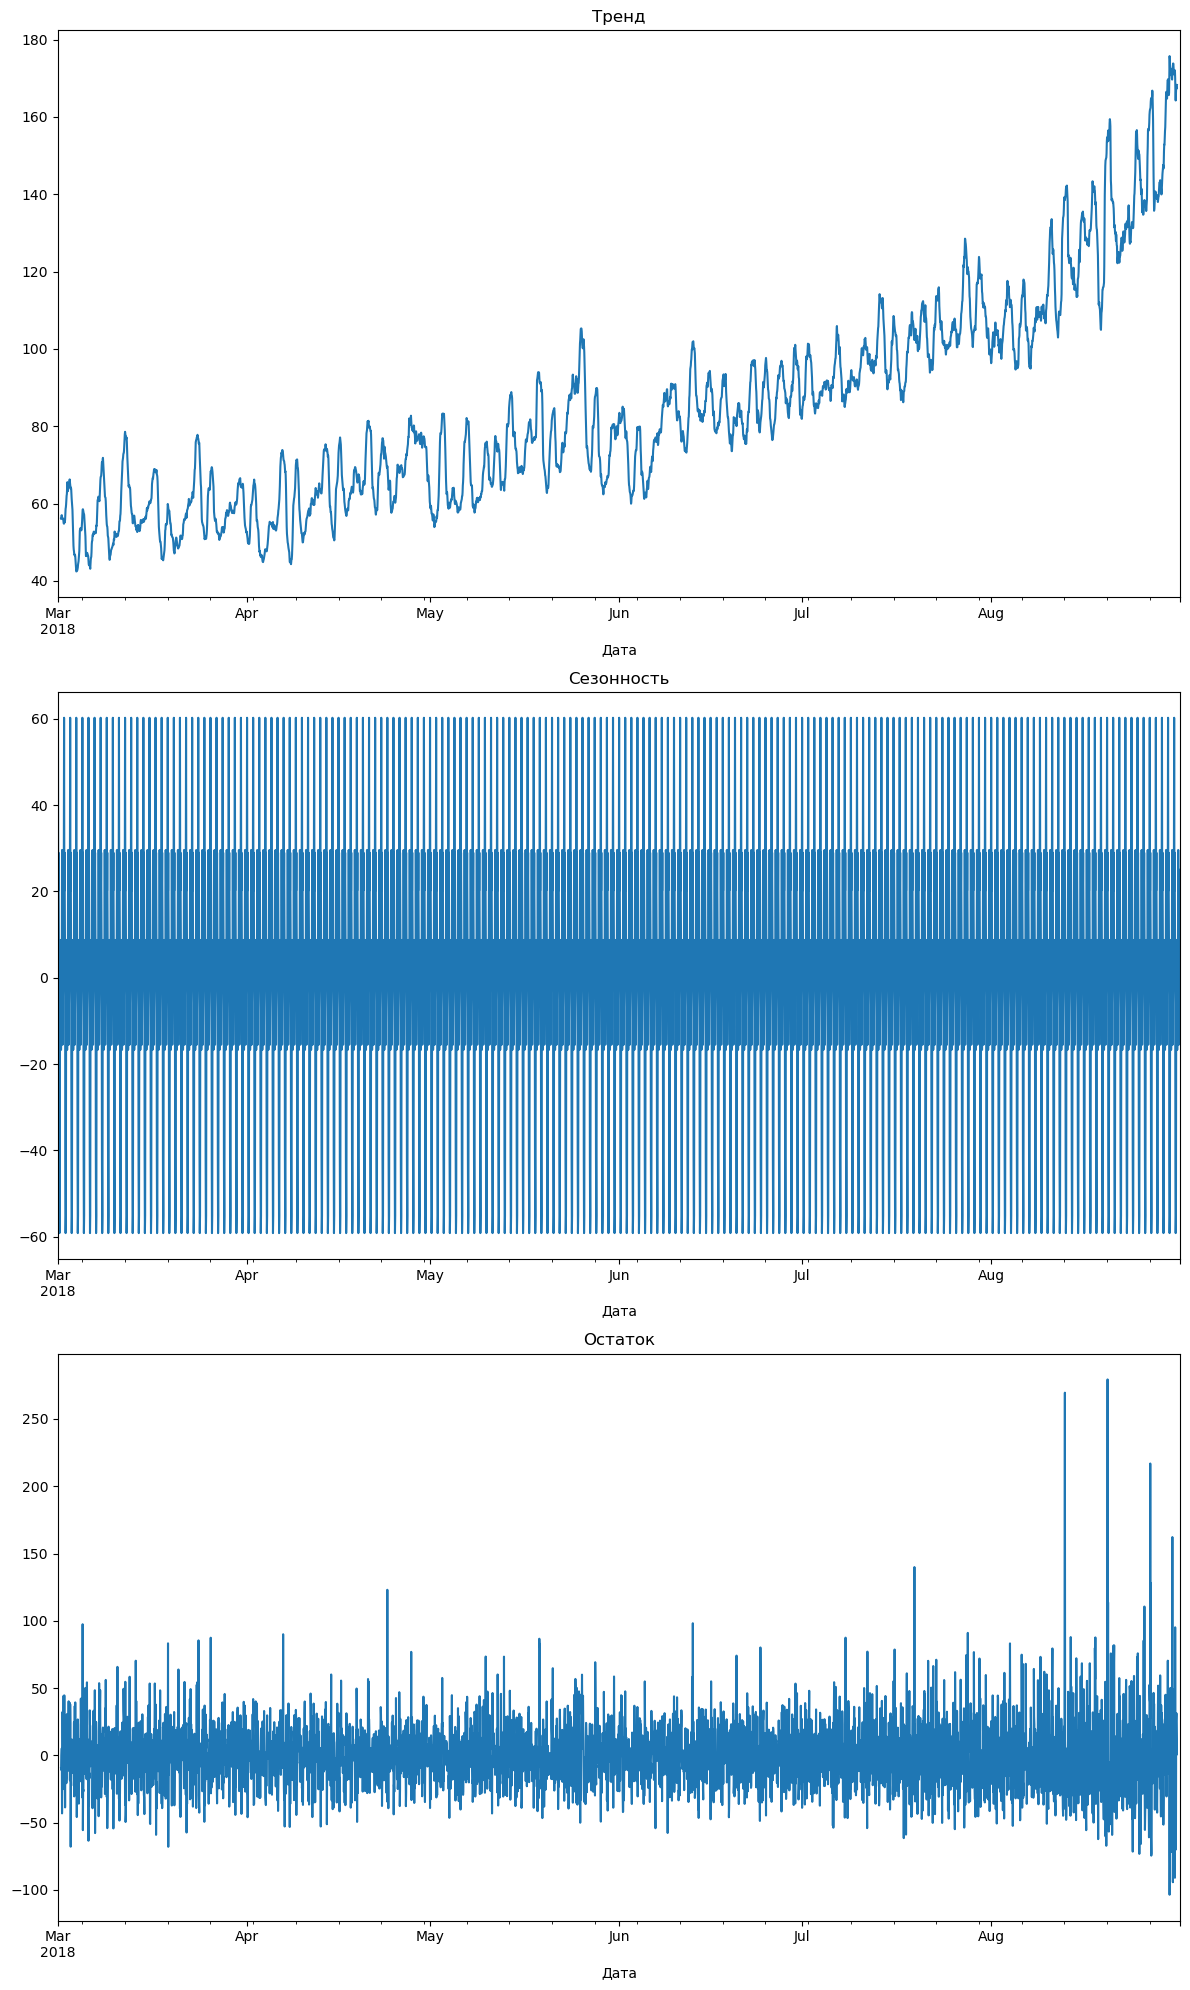

In [9]:
#Разбивка данных на тренд, сезонность и остаток
decomposed = seasonal_decompose(data)

plt.figure(figsize=(12, 20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Дата')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Дата')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.xlabel('Дата')
plt.tight_layout()

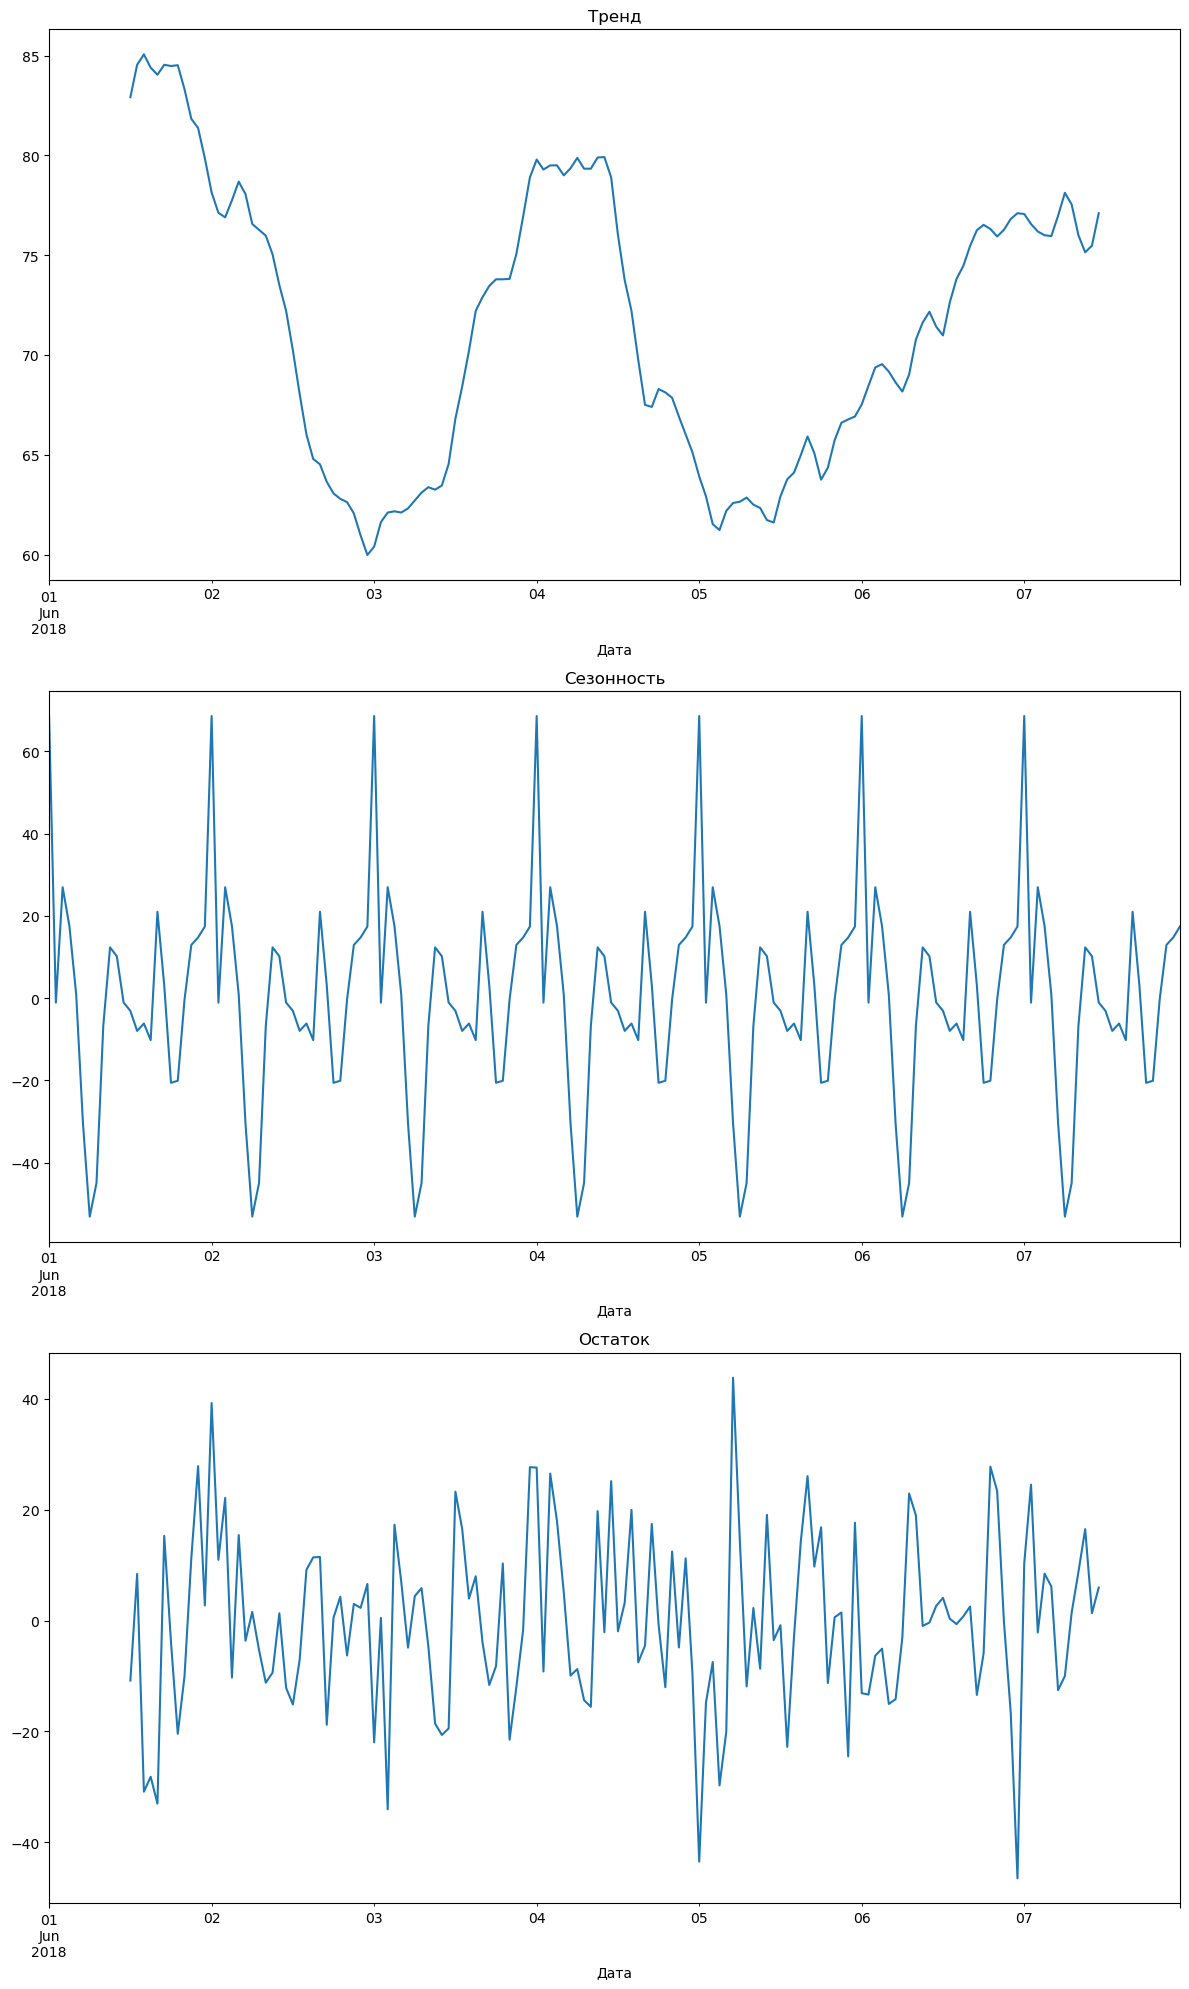

In [10]:
#Разбивка данных на тренд, сезонность и остаток за определенный период
decomposed = seasonal_decompose(data['2018-06-01':'2018-06-07'])

plt.figure(figsize=(12, 20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Дата')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Дата')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.xlabel('Дата')
plt.tight_layout()

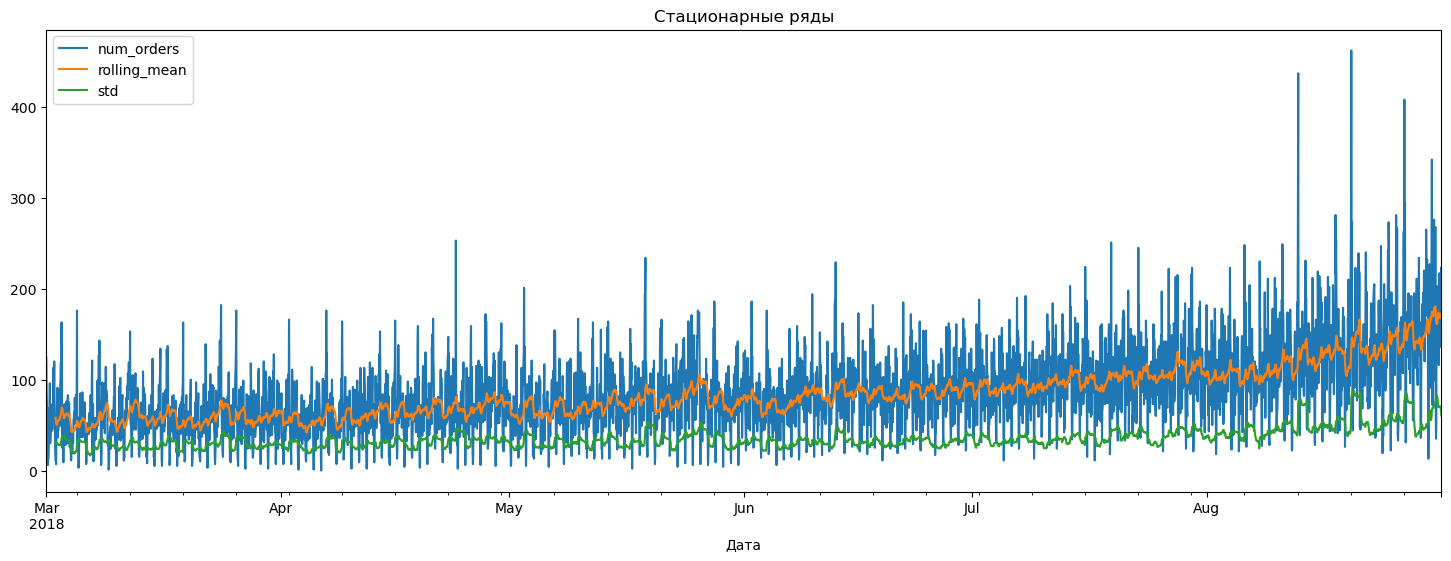

In [11]:
#Стационарые ряды
data_plot = data.copy()
data_plot['rolling_mean'] = data_plot.rolling(30).mean()
data_plot['std'] = data_plot['num_orders'].rolling(30).std()
data_plot.plot(figsize=(18, 6))
plt.title('Стационарные ряды')
plt.xlabel('Дата')
plt.show()

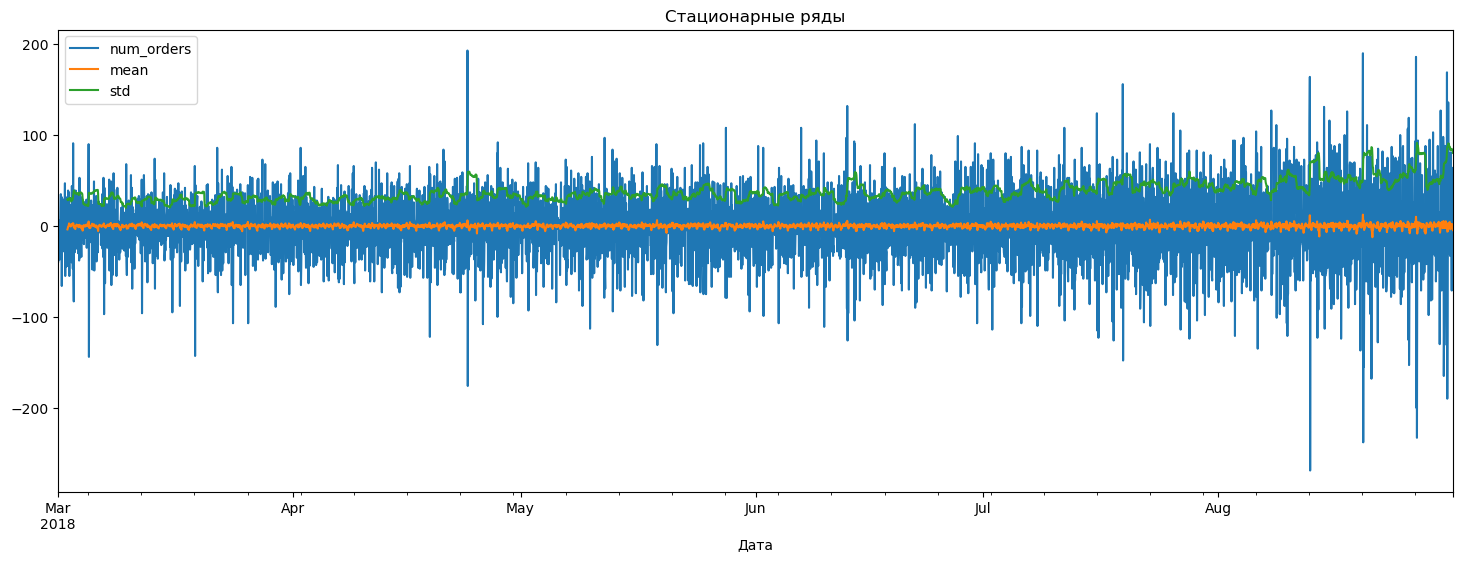

In [12]:
data_shift = data - data.shift()
data_shift['mean'] = data_shift['num_orders'].rolling(30).mean()
data_shift['std'] = data_shift['num_orders'].rolling(30).std()
data_shift.plot(figsize=(18, 6))
plt.title('Стационарные ряды')
plt.xlabel('Дата')
plt.show()

<b>Вывод</b>  
Были построены графики:  
- ресемплирования сумм заказов за каждый день  
- скользящего среднего  
- тренда, сезонности и остатка  
- стационарные ряды

## Обучение

In [13]:
#Функция для создания признаков
def make_features(data, max_lag, rolling_sum_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_sum'] = data['num_orders'].shift().rolling(rolling_sum_size).mean()

In [14]:
make_features(data, 24, 100)

In [15]:
data = data.dropna()

In [16]:
#Разбивка данных на фичи и таргеты
train, test = train_test_split(data, shuffle=False, test_size=0.1)

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [17]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(3884, 29)
(432, 29)
(3884,)
(432,)


In [18]:
#Функция для вычисления RMSE
def RMSE(target, predict):
    return (mean_squared_error(target, predict))**0.5
   
#С помощию функции make_scorer создаю метрику RMSE
RMSE_score = make_scorer(RMSE, greater_is_better=False)

In [19]:
%%time
#Линейная регресиия
my_cv = TimeSeriesSplit(n_splits=3).split(features_train)

regression = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

regression.fit(features_train, target_train)

regression_cv_score = pd.Series(cross_val_score(regression,features_train,target_train,scoring=RMSE_score,cv=my_cv)).mean()*(-1)
print('Среднее качество модели линейной регрессии на кросс-валидации:', regression_cv_score)

Среднее качество модели линейной регрессии на кросс-валидации: 28.200642009769023
Wall time: 37.1 ms


C:\Users\MSI\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
C:\Users\MSI\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = mak

In [20]:
%%time
#Случайны лес
my_cv = TimeSeriesSplit(n_splits=3).split(features_train)

forest = RandomForestRegressor()

forest_parametrs = { 'n_estimators': range(5, 30, 5),
                     'max_depth': range(1, 15, 2),
                     'min_samples_leaf': range(1,5),
                     'min_samples_split': range(2,8,2) }


forest_grid = GridSearchCV(forest, forest_parametrs, scoring=RMSE_score, cv=my_cv)
forest_grid.fit(features_train, target_train)

Wall time: 3min 15s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000002382701EDD0>,
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 15, 2),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 8, 2),
                         'n_estimators': range(5, 30, 5)},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [21]:
%%time

forest_params = forest_grid.best_params_
forest_score = forest_grid.score(features_train, target_train) * (-1)
print(forest_params)
print(forest_score)
print()

{'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 25}
14.220102792799127

Wall time: 19.7 ms


In [22]:
%%time
#CatBoostRegressor
my_cv = TimeSeriesSplit(n_splits=3).split(features_train)

model_cbr = CatBoostRegressor()

cbr_parametrs = {'learning_rate': [0.03, 0.1],
                'depth': [4, 6, 10]
               }


cbr_grid = GridSearchCV(model_cbr, cbr_parametrs, scoring=RMSE_score, cv=my_cv)
cbr_grid.fit(features_train, target_train, verbose=100)

0:	learn: 28.8252514	total: 136ms	remaining: 2m 16s
100:	learn: 17.9542208	total: 285ms	remaining: 2.54s
200:	learn: 16.1781719	total: 382ms	remaining: 1.52s
300:	learn: 14.9320599	total: 473ms	remaining: 1.1s
400:	learn: 13.6396139	total: 564ms	remaining: 842ms
500:	learn: 12.5540594	total: 658ms	remaining: 656ms
600:	learn: 11.7318042	total: 750ms	remaining: 498ms
700:	learn: 11.0009932	total: 838ms	remaining: 357ms
800:	learn: 10.2931792	total: 938ms	remaining: 233ms
900:	learn: 9.6451514	total: 1.03s	remaining: 113ms
999:	learn: 9.0708048	total: 1.12s	remaining: 0us
0:	learn: 31.9422362	total: 3.11ms	remaining: 3.11s
100:	learn: 20.1802286	total: 191ms	remaining: 1.7s
200:	learn: 18.3938269	total: 311ms	remaining: 1.24s
300:	learn: 17.3748681	total: 426ms	remaining: 990ms
400:	learn: 16.4907964	total: 546ms	remaining: 816ms
500:	learn: 15.7141243	total: 665ms	remaining: 663ms
600:	learn: 15.0811883	total: 784ms	remaining: 521ms
700:	learn: 14.5079295	total: 897ms	remaining: 383ms
8

400:	learn: 10.2040848	total: 18.7s	remaining: 28s
500:	learn: 8.7603043	total: 23.3s	remaining: 23.2s
600:	learn: 7.5392818	total: 27.9s	remaining: 18.5s
700:	learn: 6.5940609	total: 32.5s	remaining: 13.9s
800:	learn: 5.6901193	total: 37s	remaining: 9.2s
900:	learn: 4.8986646	total: 41.6s	remaining: 4.58s
999:	learn: 4.2840366	total: 46.2s	remaining: 0us
0:	learn: 27.9545113	total: 45.8ms	remaining: 45.8s
100:	learn: 6.1318829	total: 3.52s	remaining: 31.3s
200:	learn: 2.3985189	total: 7.05s	remaining: 28s
300:	learn: 0.8422297	total: 10.6s	remaining: 24.5s
400:	learn: 0.3509288	total: 14s	remaining: 20.9s
500:	learn: 0.1437123	total: 17.4s	remaining: 17.3s
600:	learn: 0.0568038	total: 20.9s	remaining: 13.9s
700:	learn: 0.0248833	total: 24.3s	remaining: 10.4s
800:	learn: 0.0118659	total: 27.8s	remaining: 6.91s
900:	learn: 0.0047182	total: 31.2s	remaining: 3.43s
999:	learn: 0.0020434	total: 34.6s	remaining: 0us
0:	learn: 30.9866482	total: 63.1ms	remaining: 1m 3s
100:	learn: 9.2504096	to

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000023826FEF430>,
             estimator=<catboost.core.CatBoostRegressor object at 0x000002382911D370>,
             param_grid={'depth': [4, 6, 10], 'learning_rate': [0.03, 0.1]},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [23]:
%%time

cbr_params = cbr_grid.best_params_
cbr_score = cbr_grid.score(features_train, target_train) * (-1)
print(cbr_params)
print(cbr_score)
print()

{'depth': 4, 'learning_rate': 0.03}
17.345132244233966

Wall time: 16 ms


<b>Вывод</b>  
Обучены три модели: линейная регрессия, случайный лес, CatBoostRegressor, на тренировочных выборках, и подобраны параметры с помощью кросс-валидации. Получены RMSE моделей.

## Тестирование

In [24]:
%%time
#Обучаю модель
regression_model = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
regression_model.fit(features_train, target_train)
regression_model_predictions = regression_model.predict(features_test)

#Определяю метрику RMSE
regression_RMSE = round(RMSE(target_test, regression_model_predictions), 3)
print('RMSE модели Линейной регрессии:', regression_RMSE)

RMSE модели Линейной регрессии: 47.083
Wall time: 20.2 ms


C:\Users\MSI\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


In [25]:
%%time
#Обучаю модель на оптимальных гиперпараметрах
forest_model = RandomForestRegressor(random_state=42,
                                     max_depth=forest_params['max_depth'],
                                     min_samples_leaf = forest_params['min_samples_leaf'],
                                     min_samples_split = forest_params['min_samples_split'],
                                     n_estimators = forest_params['n_estimators'])

forest_model.fit(features_train, target_train)
forest_model_predictions = forest_model.predict(features_test)

#Определяю метрику RMSE
forest_RMSE = round(RMSE(target_test, forest_model_predictions), 3)
print('RMSE модели Случайного леса:', forest_RMSE)

RMSE модели Случайного леса: 45.163
Wall time: 902 ms


In [26]:
%%time
model_cbr_test = CatBoostRegressor(learning_rate=cbr_params['learning_rate'], depth=cbr_params['depth'])

model_cbr_test.fit(features_train, target_train, verbose=100)
cbr_test_predictions = model_cbr_test.predict(features_test)

#Определяю метрику RMSE
cbr_RMSE = round(RMSE(target_test, cbr_test_predictions), 3)
print('RMSE модели CatBoostRegressor:', cbr_RMSE)

0:	learn: 38.1982933	total: 6.14ms	remaining: 6.14s
100:	learn: 24.2910629	total: 204ms	remaining: 1.82s
200:	learn: 22.7529456	total: 360ms	remaining: 1.43s
300:	learn: 21.7867358	total: 516ms	remaining: 1.2s
400:	learn: 20.8238648	total: 673ms	remaining: 1s
500:	learn: 20.0105500	total: 829ms	remaining: 826ms
600:	learn: 19.3253240	total: 991ms	remaining: 658ms
700:	learn: 18.7516431	total: 1.15s	remaining: 490ms
800:	learn: 18.2306287	total: 1.31s	remaining: 325ms
900:	learn: 17.7735142	total: 1.46s	remaining: 161ms
999:	learn: 17.3451322	total: 1.61s	remaining: 0us
RMSE модели CatBoostRegressor: 40.933
Wall time: 1.81 s


<b>Вывод</b>  
Модели проверены на тестовых выборках. Лучше всех показала себя модель CatBoostRegressor с RMSE - 40.933, что соответсвует условиям задачи